<h1><left><font size="5">Forecasting Laboratory Earthquakes Using Seismic Acoustic Time-Series: Continuation (v1)</font>
    <h2><left><font size="4">Data Source & Host: Los Alamos National Laboratory</font></left></h2>


# <a id='0'>Contents</a>

- <a href='#1'>Import Packages</a>    
- <a href='#2'>Re: Signal Processing & Feature engineering</a>
- <a href='#3'>Re: GBM Model</a>
- <a href='#4'>Submission File</a>  

# <a id='1'>Import Packages</a>

In [2]:
import os 
import time
import csv
import warnings
import numpy as np
from numpy.fft import rfft
import pandas as pd
from tqdm import tqdm_notebook, tnrange
import lightgbm as lgb
from joblib import dump, load
import dask
import dask_searchcv as dcv
from scipy import stats
from scipy.signal import hann, hilbert, convolve 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve, GridSearchCV
from collections import deque, defaultdict
from IPython.core.interactiveshell import InteractiveShell

# InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings("ignore")
pd.options.display.precision = 10
%matplotlib inline

# <a id='2'>Re: Signal Processing & Feature engineering</a>

### Import Prior Data

##### Features Matrix

In [2]:
features_matrix = pd.read_csv('features_matrix.csv')

##### FFT Coefficients (Transformed)

In [6]:
features_fourier = pd.read_csv('features_fourier_PCA.csv', header=None)

##### Target

In [4]:
target = pd.read_csv('target.csv', header=None)

##### PCA Model (transform FFT Coefficients)

In [3]:
PCA_Model = load('PCA_FourierTransformer.joblib') 

### New Feature Extraction

In [4]:
def get_sub_features(signal):
    
    def power(sig):
        return sum(map(lambda x: x**2, sig))/len(sig)
        
    features = pd.DataFrame({
                             'power': power(signal),
                             'mean': signal.mean(),
                             'skew': signal.skew(),
                             'kurtosis': stats.kurtosis(signal, fisher=False),
                             'std': signal.std()
                            }, index=[0]).astype('float32')
    return features

In [5]:
def get_features(signal):
    
    def sta_lta(signal, sta_window, lta_window):
        l1 = lambda sig: sum(abs(sig)) / len(sig)
        return np.float32( l1(signal[-sta_window:]) / l1(signal[-lta_window:]) )
    
    
    # features_0 = get_sub_features(raw_signal)
    output = pd.DataFrame({'std': signal.std(),
                           'sta_lta_0.5': sta_lta(signal,len(signal)//2, 150_000),
                           'sta_lta_0.25': sta_lta(signal,len(signal)//4, 150_000)
                            }, index=[0]).astype('float32')
    
    #features_1 = get_sub_features(raw_signal[0:75_000])
    #features_2 = get_sub_features(raw_signal[75_000:])

    #output = pd.concat([output,features_1,features_2], axis=1)
    #output.columns = ['std', 'sta_lta_0.5', 'sta_lta_0.25',
    #                  'power1', 'mean1', 'skew1', 'kurtosis1', 'std1', 
    #                  'power2', 'mean2', 'skew2', 'kurtosis2', 'std2']
    
    return output 

In [83]:
reader = pd.read_csv('train.csv', iterator=True, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

window = reader.get_chunk(150_000)
raw_signal = window.acoustic_data
data = pd.DataFrame()

interval = 4_000
iterations = (629_145_480-150_000)//interval + 1

for _ in tqdm_notebook(range(iterations), desc='Feature Extraction'):
    train_row = get_features(raw_signal)
    data = pd.concat([data,train_row], ignore_index=True, axis=0)

    try:
        window = reader.get_chunk(interval)
    except:
        continue 

    raw_signal = raw_signal[interval:].append(window.acoustic_data)

### Join New Features

In [94]:
new_features = pd.concat([features_matrix.loc[:,'power':'kurtosis'], data, features_fourier], axis=1)

# <a id='3'>Re: GBM Model</a>

In [9]:
param_grid = [{'learning_rate': [0.02, 0.06], 
              'num_leaves':[20, 40],
              'min_data_in_leaf': [1000,2000],
              'n_estimators': [100,300,500],
              'max_depth':[4, 8]
              }, 
              {'learning_rate': [0.02, 0.06], 
              'num_leaves':[100, 200],
              'min_data_in_leaf': [300, 1000],
              'n_estimators': [50, 100],
              'max_depth':[8, 12]
              }] 

In [10]:
model = GridSearchCV(estimator=lgb.LGBMRegressor(), 
                     param_grid=param_grid, 
                     cv=5, 
                     scoring='neg_mean_absolute_error',
                     n_jobs=-1,
                     verbose=10,
                     return_train_score=True)

In [11]:
model.fit(new_features,target)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 2

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'learning_rate': [0.02, 0.06], 'num_leaves': [20, 40], 'min_data_in_leaf': [1000, 2000], 'n_estimators': [100, 300, 500], 'max_depth': [4, 8]}, {'learning_rate': [0.02, 0.06], 'num_leaves': [100, 200], 'min_data_in_leaf': [300, 1000], 'n_estimators': [50, 100], 'max_depth': [8, 12]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=10)

In [16]:
def plot_model_train_cv_error(model):
    fig = plt.figure(figsize=(16,6))
    plt.title('Mean Training & CV Error')
    plt.xlabel('Model Number')
    plt.ylabel('ylabelative Mean Absolute Error')
    plt.plot(model.cv_results_['mean_train_score'], color='g', label='Training')
    plt.legend(loc=(0.75, 0.90))
    plt.plot(model.cv_results_['mean_test_score'], color='r', label='CV')
    plt.legend(loc=(0.75, 0.85))

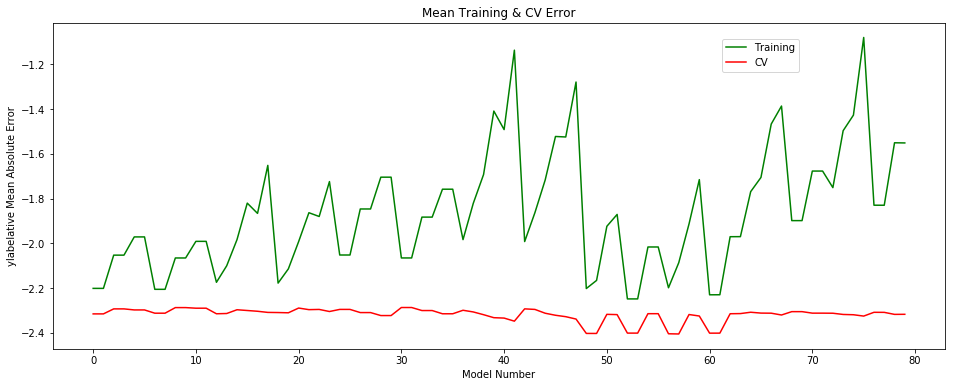

In [17]:
plot_model_train_cv_error(model)

In [35]:
model.best_params_

{'learning_rate': 0.06,
 'max_depth': 4,
 'min_data_in_leaf': 2000,
 'n_estimators': 100,
 'num_leaves': 20}

In [60]:
def plot_feature_importance(model, importance='gain'):
    M1 = lgb.LGBMRegressor(**model.best_params_, importance_type=importance)
    M1.fit(new_features, target)
    ranked_features_ndx = sorted(range(len(M1.feature_importances_)), key=lambda x: M1.feature_importances_[x])


    objects = [new_features.keys()[i] for i in ranked_features_ndx]
    y_pos = np.arange(len(objects))
    importance = [M1.feature_importances_[i] for i in ranked_features_ndx]

    fig = plt.figure(figsize=(16,64))
    plt.barh(y_pos, importance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Gain')
    plt.title('Feature Importance')

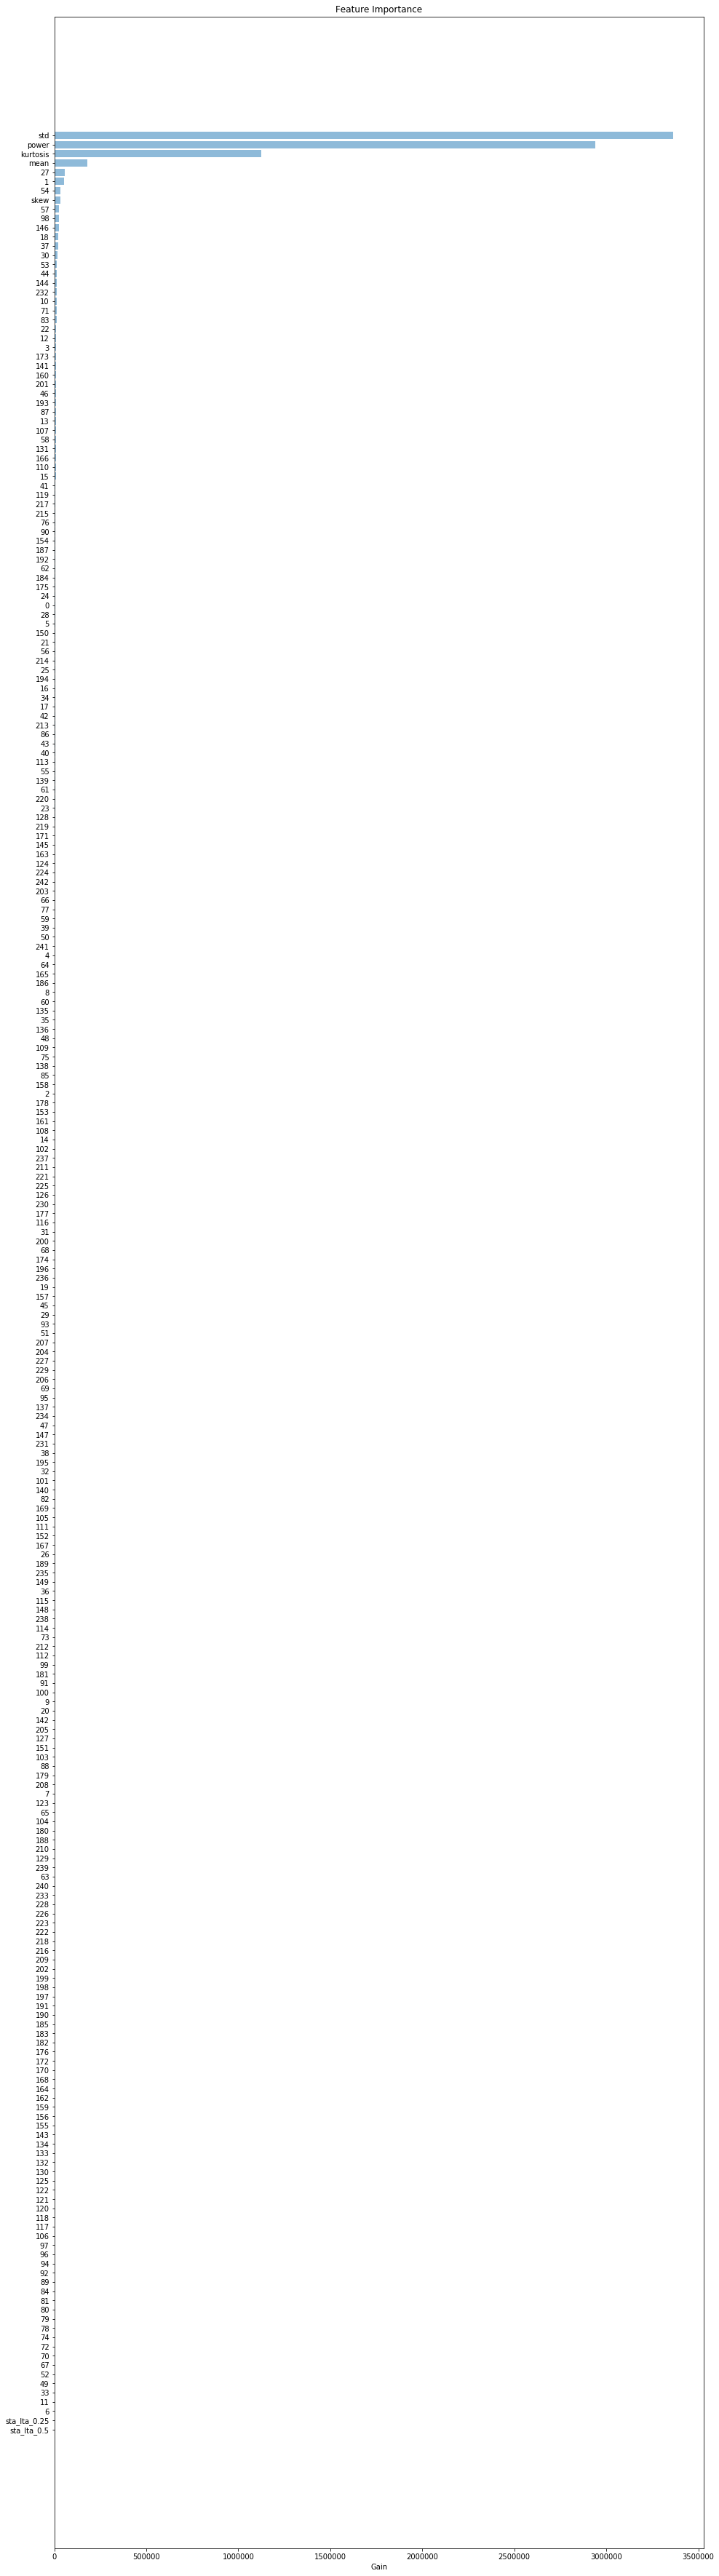

In [61]:
plot_feature_importance(model)

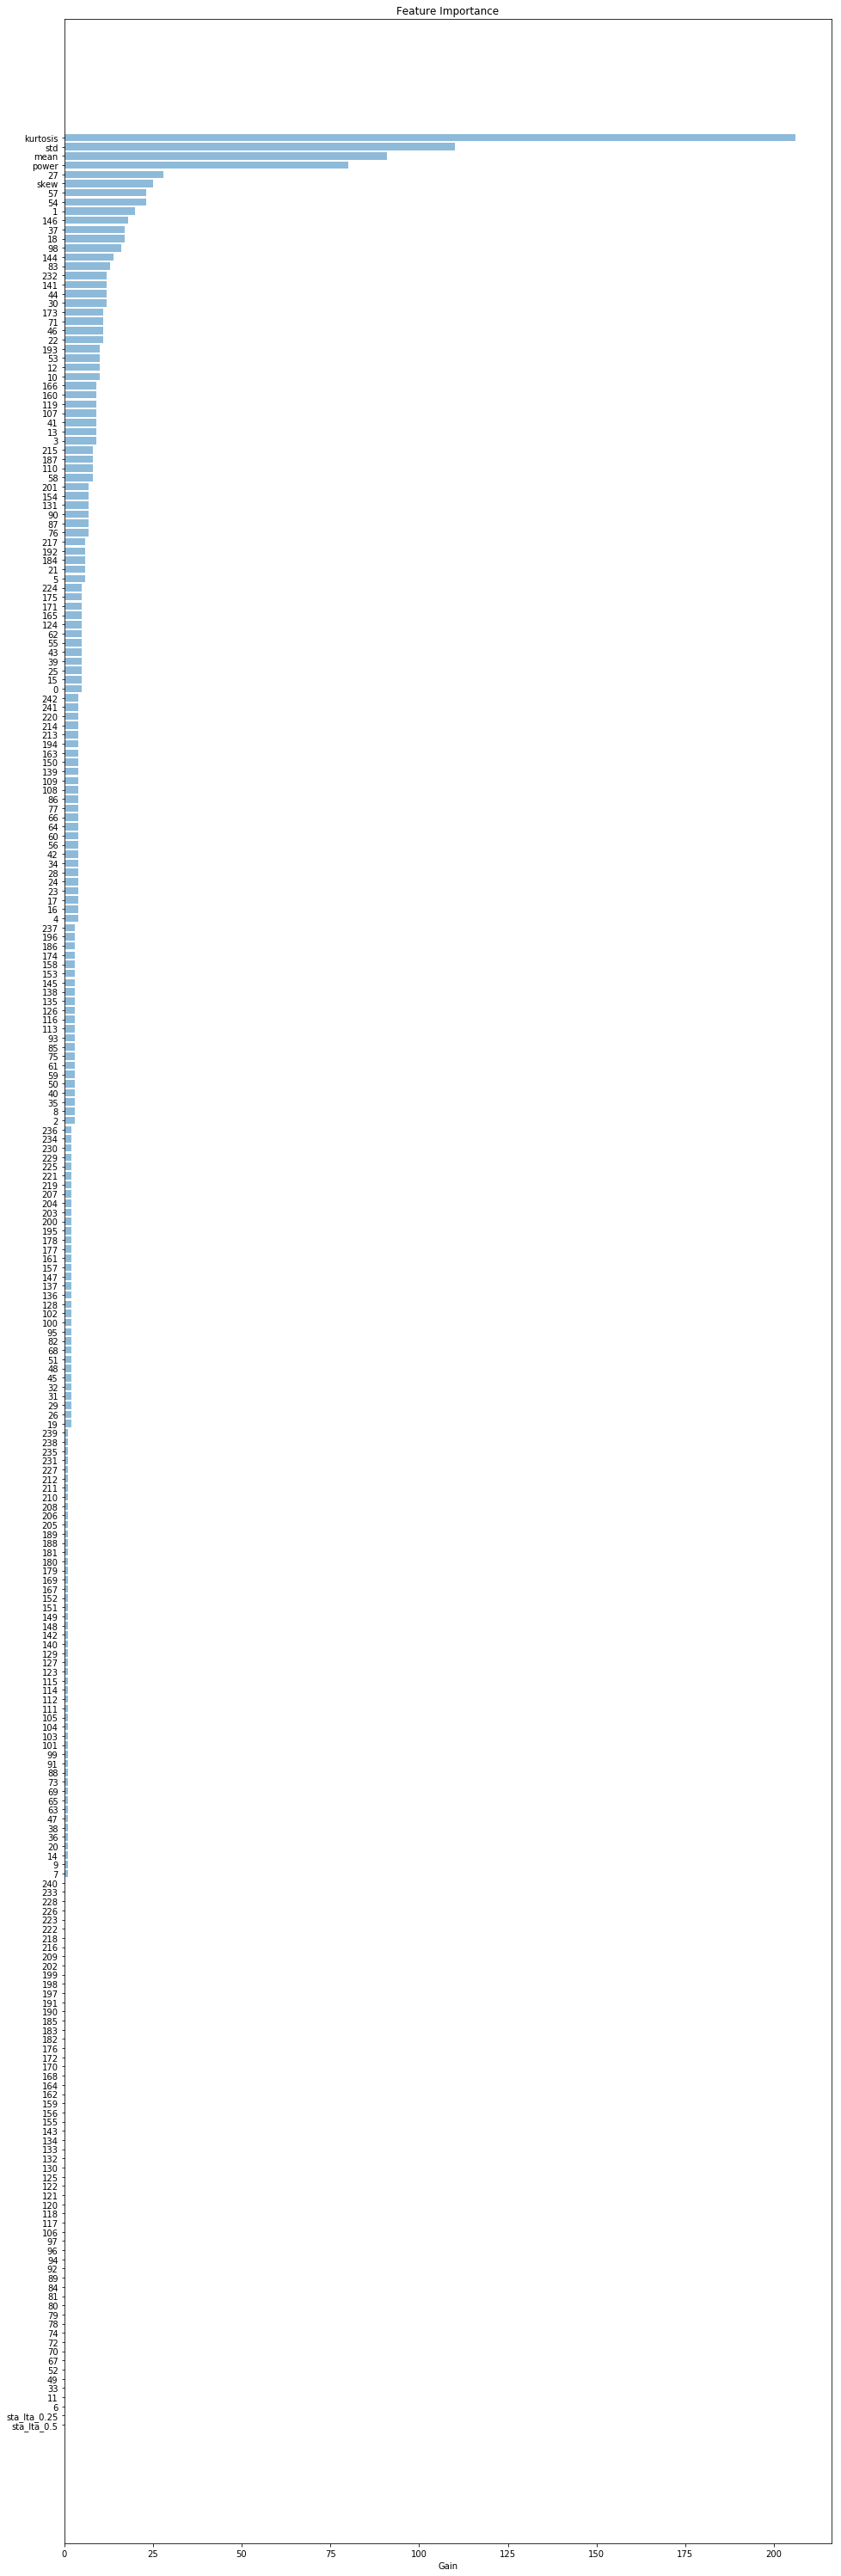

In [46]:
plot_feature_importance(model, importance='split')

# <a id='4'>Submission File</a>

In [10]:
def get_features(signal):
    
    def sta_lta(signal, sta_window, lta_window):
        l1 = lambda sig: sum(abs(sig)) / len(sig)
        return np.float32( l1(signal[-sta_window:]) / l1(signal[-lta_window:]) )
    
    def power(sig):
        return sum(map(lambda x: x**2, sig))/len(sig)
    
    output = pd.DataFrame({'power': power(signal),
                            'mean': signal.mean(),
                            'skew': signal.skew(),
                            'kurtosis': stats.kurtosis(signal, fisher=False),
                            'std': signal.std(),
                            'sta_lta_0.5': sta_lta(signal,len(signal)//2, 150_000),
                            'sta_lta_0.25': sta_lta(signal,len(signal)//4, 150_000)
                           }, index=[0]).astype('float32')

    
    return output 

In [9]:
def get_fourier(signal):
    trans_signal = (signal-signal.mean())*hann(150_000)
    # compute real FFT and take lower frequnecies of interest
    coefficients = np.fft.rfft(trans_signal)[1:16668]
    return abs(coefficients)

In [12]:
path = './test'
with open('submission1.csv', 'a', newline='') as f:
    wr = csv.writer(f)
    wr.writerow(['seg_id','time_to_failure'])
    
    for seg in tqdm_notebook(os.listdir(path), desc='Creating Submission'):
        data = pd.read_csv(path+'/'+seg).acoustic_data
        features_vector = get_features(data)
        features_fourier = PCA_Model.transform(get_fourier(data).reshape(1,-1))
        features = pd.concat([features_vector, pd.DataFrame(features_fourier)], axis=1)
        model_y = model.predict(features)
        wr.writerow([seg.split('.')[0] , model_y[0]])